# Importing Libraries

In [11]:
import cv2
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import networkx as nx    # for graph generation

## Loading data

In [12]:
base_data_dir = pathlib.Path('data/FloodNet-Supervised_v1.0/')
train_dir = base_data_dir/'train'
test_dir = base_data_dir/'test'
valid_dir = base_data_dir/'val'
train_img_dir, train_mask_dir = train_dir/'train-org-img', train_dir/'train-label-img'
valid_img_dir, valid_mask_dir = valid_dir/'val-org-img', valid_dir/'val-label-img'
test_img_dir, test_mask_dir = test_dir/'test-org-img', test_dir/'test-label-img'

In [13]:
# Fetching all the jpgs from the img folder
# the glob module is used to retrieve files/pathnames matching a specified pattern
train_images = list(train_img_dir.glob('*.jpg'))
valid_images = list(valid_img_dir.glob('*.jpg'))
test_images = list(test_img_dir.glob('*.jpg'))
print(f"No of Train Images: {len(train_images)}, No of Valid Images: {len(valid_images)}, No of Test Images: {len(test_images)}")
train_images[:5]

No of Train Images: 1445, No of Valid Images: 450, No of Test Images: 448


[PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/9036.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/6525.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/10182.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/7037.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/6992.jpg')]

In [5]:
def label_mask_path(mask_dir, image_path):
    return mask_dir/f'{image_path.stem}_lab.png'
idx = 42
img_path = train_images[idx]
label_path = label_mask_path(train_mask_dir, img_path)
print(img_path)
print(label_path)

data/FloodNet-Supervised_v1.0/train/train-org-img/6960.jpg
data/FloodNet-Supervised_v1.0/train/train-label-img/6960_lab.png


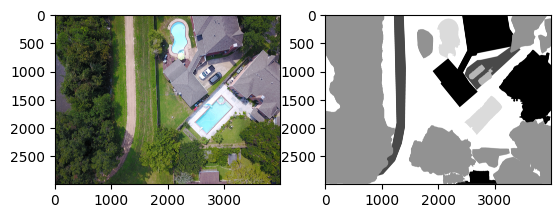

In [6]:
plt.subplot(121)
img = Image.open(img_path)
img = np.asarray(img)
plt.imshow(img)
plt.subplot(122)
mask = Image.open(label_path)
mask = np.asarray(mask)
plt.imshow(mask, cmap = 'gray');

In [7]:
cat_to_idx =  {'Background':0, 'Building_f':1, 'Building_nf':2, 'Road_f':3, 'Road_nf':4, 
               'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}
idx_to_cat = {v:k for k, v in cat_to_idx.items()}

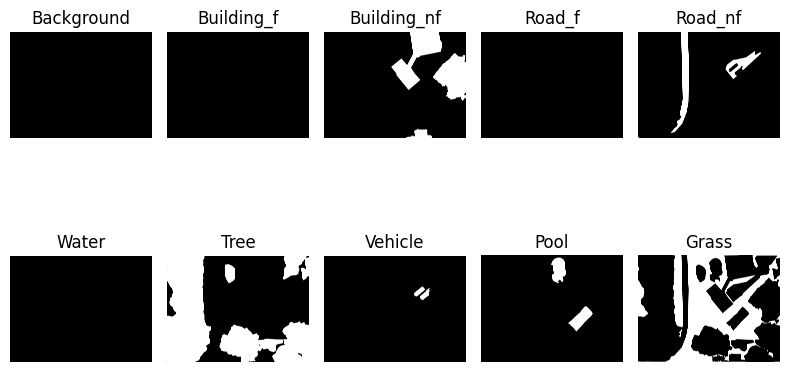

In [8]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, sharex=True, figsize = (8,8), tight_layout = True)
all_masks = []
kernel = np.ones((5,5))
# mask = cv2.GaussianBlur(mask, (5,5), cv2.BORDER_DEFAULT).astype('uint8')
for i in range(10):
    mask_sub = (mask == i).astype(np.uint8)
    row, col = i//5, i%5
    # mask_sub = cv2.erode(mask_sub, kernel=kernel, iterations = 1)
    mask_sub = cv2.dilate(mask_sub, kernel=kernel, iterations = 3)
    axes[row, col].imshow(mask_sub, cmap = 'gray')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'{idx_to_cat[i]}')
    all_masks.append(mask_sub)

In [9]:
objects_and_contours = {}
i = 0
for idx, mask in enumerate(all_masks):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Removing Flooded or non flooded from name
    base_object_name = idx_to_cat[idx]
    if base_object_name.find(' ') != -1:
        base_object_name = base_object_name[:base_object_name.find(' ')]
    for contour in contours:
        total_area = mask.shape[0]*mask.shape[1]
        contour_mask = np.zeros_like(mask)
        area = cv2.contourArea(contour)/(total_area)
        # Check area only if it is grass or tree lane
        if (idx==6 or idx==9) and (area < 0.001):
            continue
        contour_mask = cv2.fillPoly(contour_mask, [contour], (255))
        object_name = f'{base_object_name}_{i}'
        i+=1
        objects_and_contours[object_name] = contour_mask

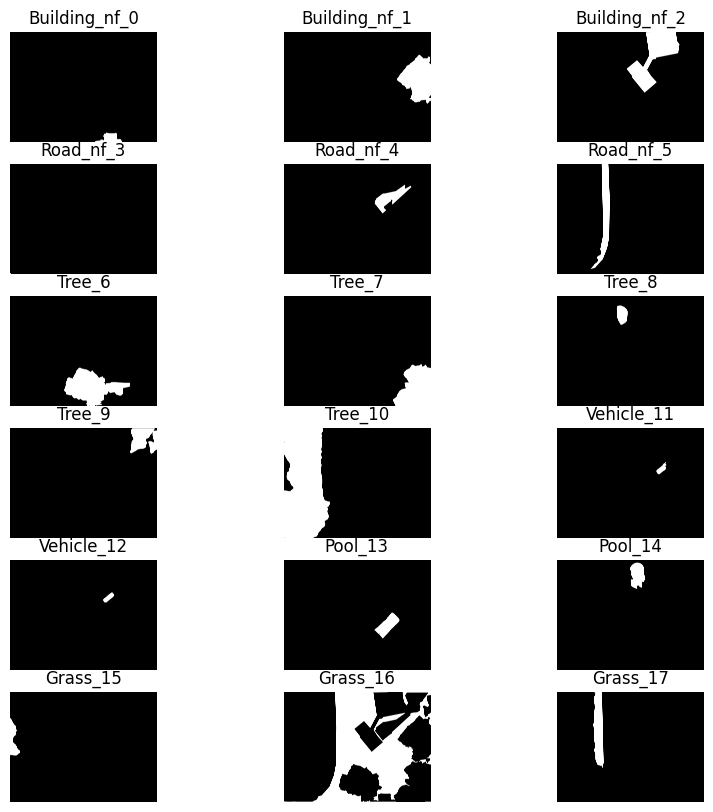

In [10]:
# idx = 1
# plt.figure(figsize = (10,10))
# for contour in contours:
#     total_area = mask.shape[0]*mask.shape[1]
#     m = np.zeros_like(mask)
#     plt.subplot(5, 5, idx)
#     # area = cv2.contourArea(contour)/(total_area)
#     # if area < 0.001:
#     #     continue
#     m = cv2.fillPoly(m, [contour], (255))
#     plt.imshow(m, cmap = 'gray')
#     plt.title(f'{hierarchy[0][idx-1]}')
#     idx+=1
plt.figure(figsize = (10,10))
plt.subplots_adjust(hspace=0.2)
total_items = len(objects_and_contours)
ncols = 3
nrows = total_items // ncols + (total_items % ncols > 0)
idx = 1
for label, mask in objects_and_contours.items():
    plt.subplot(nrows, ncols, idx)
    plt.imshow(mask, cmap = 'gray')
    plt.title(f'{label}')
    plt.axis('off')
    idx+=1 
plt.show()

In [11]:
dilate_kernel = np.ones((5,5))
graph = nx.Graph()
for ref_img, ref_mask in objects_and_contours.items():
    ref_mask = cv2.dilate(ref_mask, kernel=dilate_kernel, iterations=2)
    for it_img, it_mask in objects_and_contours.items():
        if it_img == ref_img:
            continue
        it_mask = cv2.dilate(it_mask, kernel=dilate_kernel, iterations=2)
        connected = np.any(np.logical_and(ref_mask, it_mask))
        if connected:
            edge = (it_img, ref_img)
            if not(graph.has_edge(*edge)):
                graph.add_edge(*edge)

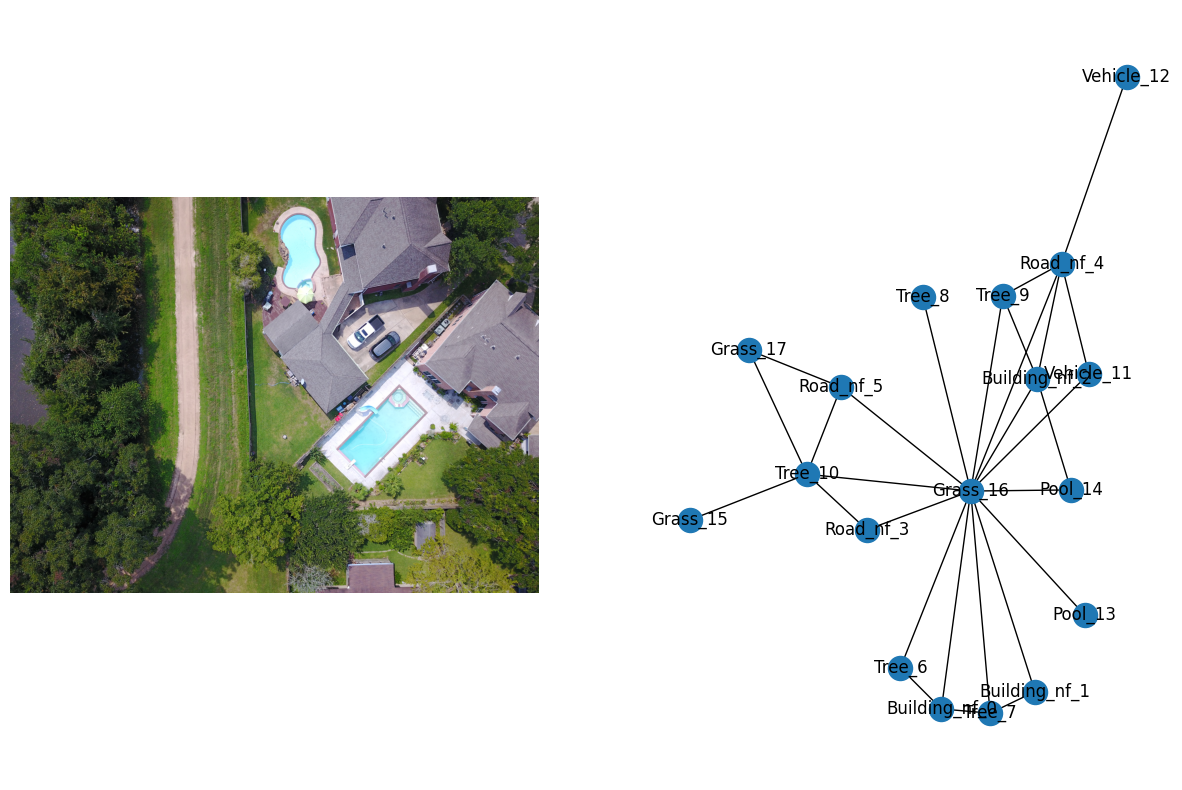

In [12]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,10))
img = Image.open(img_path)
img = np.asarray(img)
img_mask = Image.open(label_path)
img_mask = np.asarray(img_mask)

axes[0].imshow(img)
axes[0].axis('off')
# axes[1].imshow(img_mask, cmap = 'gray')
# axes[1].axis('off')
nx.draw(graph, with_labels = True, ax = axes[1])